# Desafio 3

In [1]:
import pandas as pd
import numpy as np
import missingno as msngo
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

pd.options.display.max_columns = None

In [2]:
df = pd.read_excel('Data/Telco-Customer-Churn.xlsx')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Realizar un análisis exploratorio de los datos para comprender las características y la distribución de los datos.

In [3]:
df.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Descripcion de variables numericas

In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Distribucion de variable categoricas

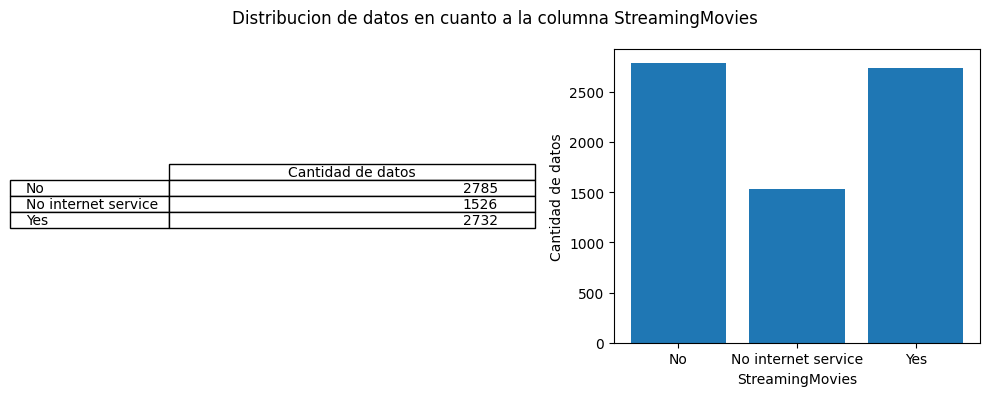

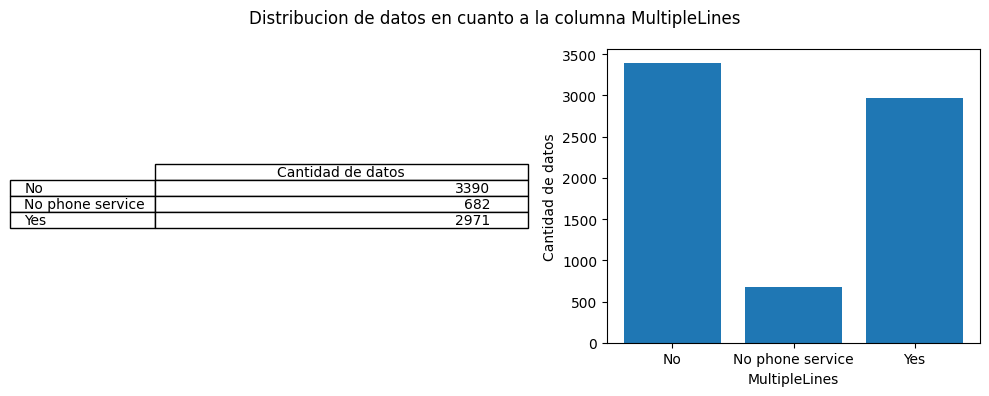

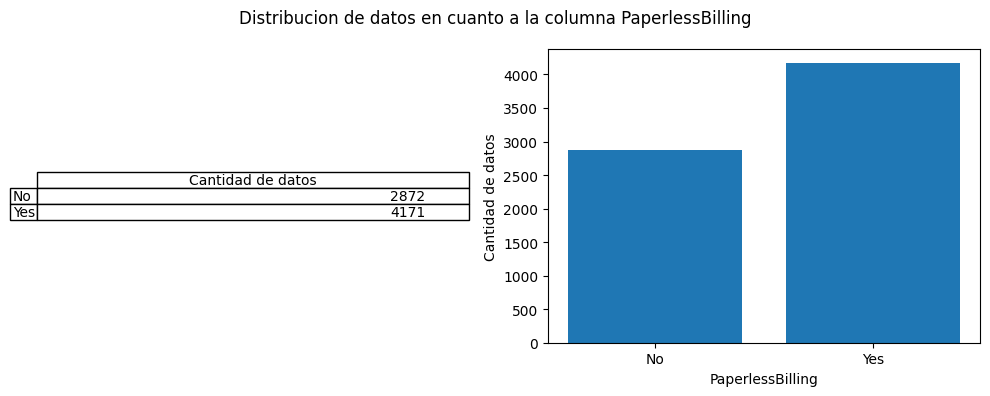

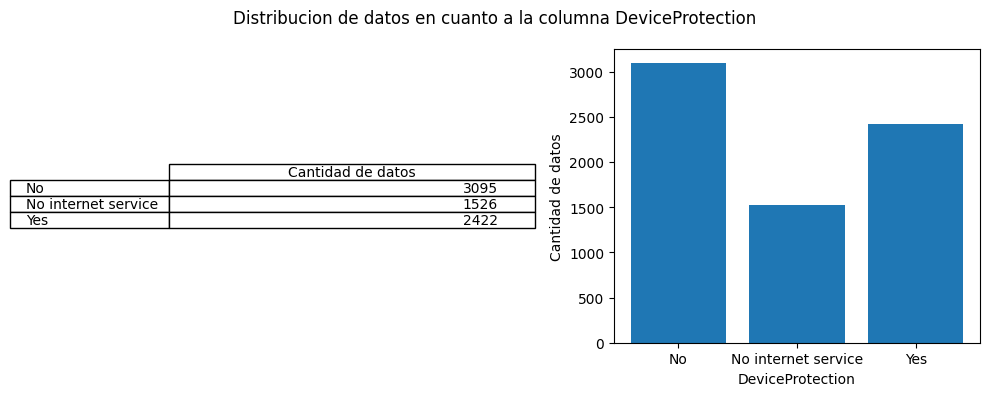

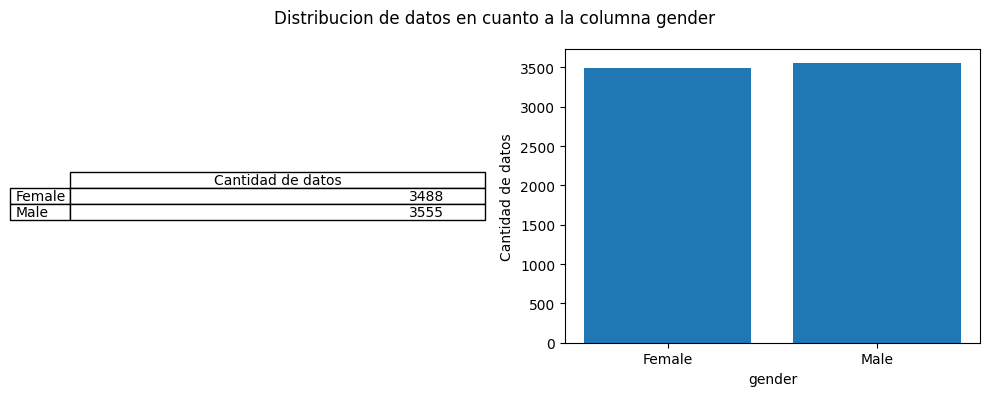

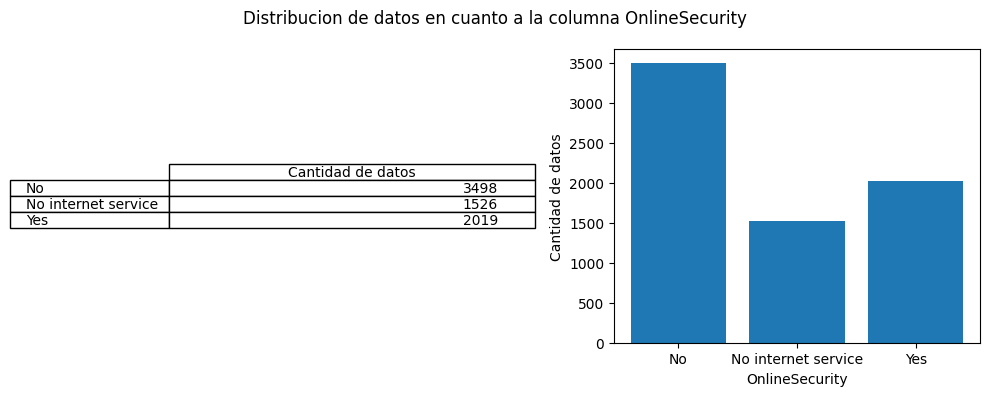

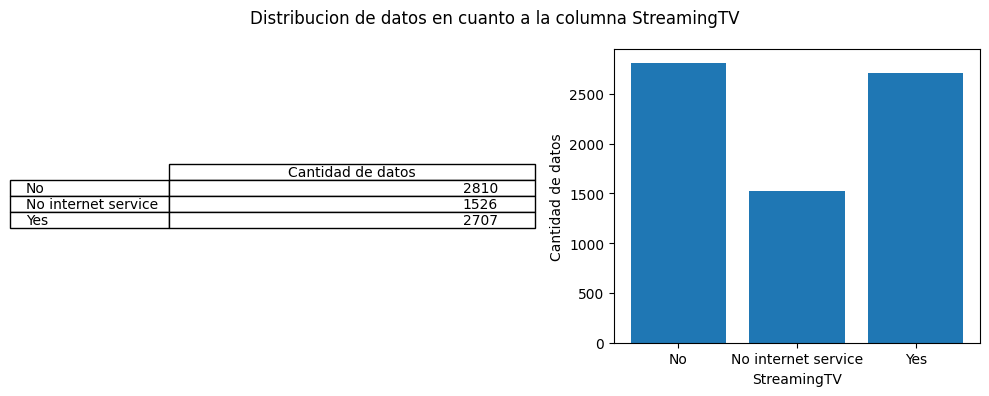

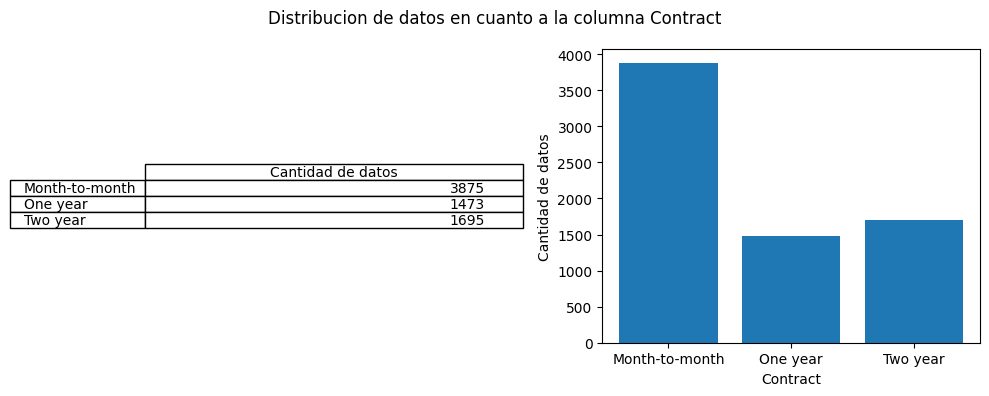

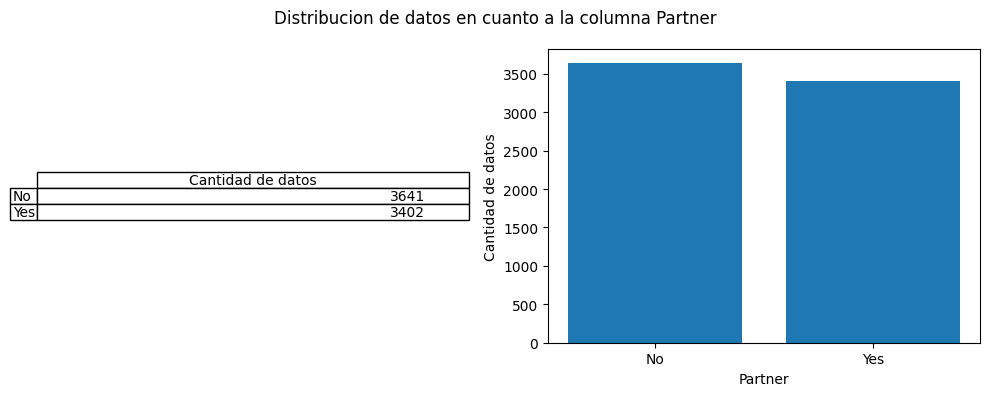

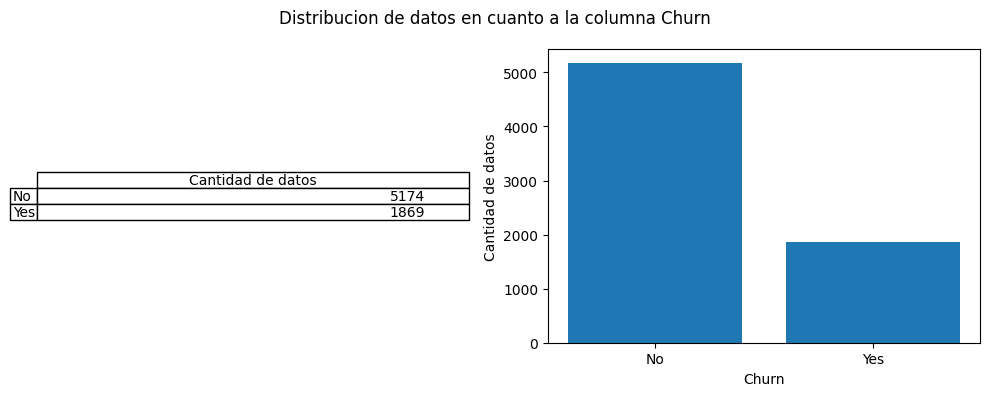

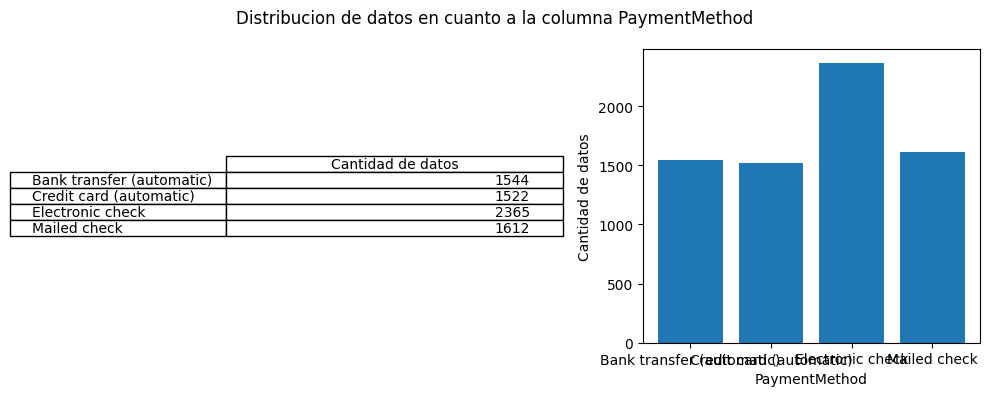

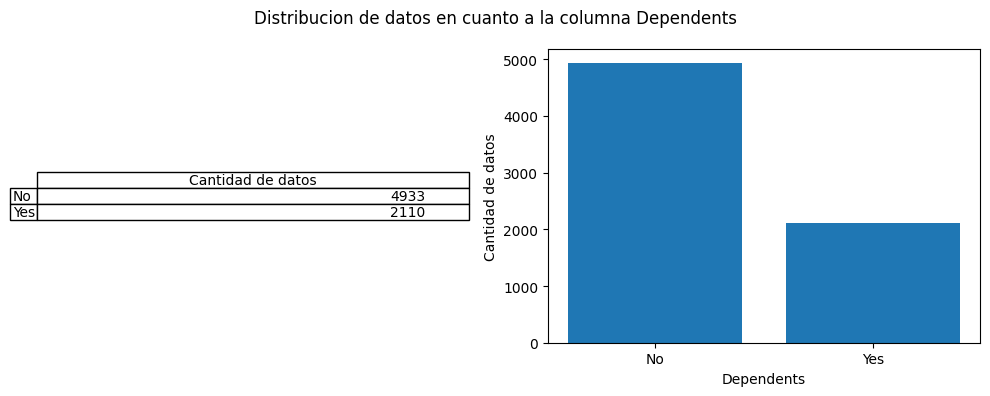

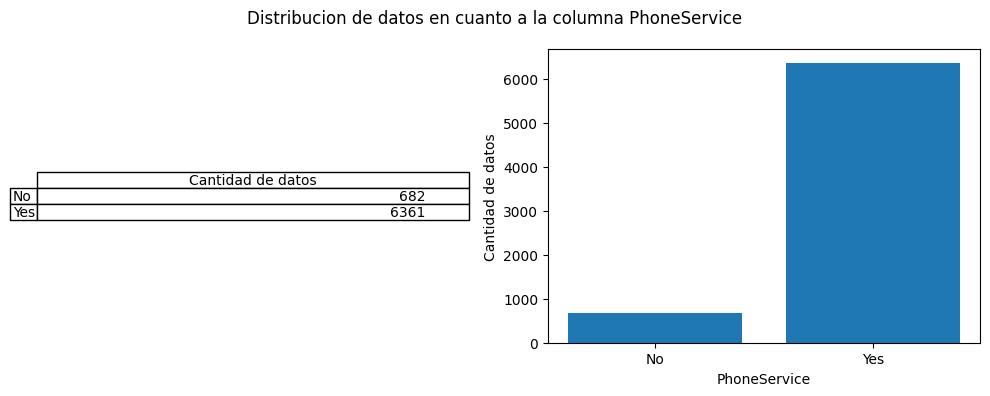

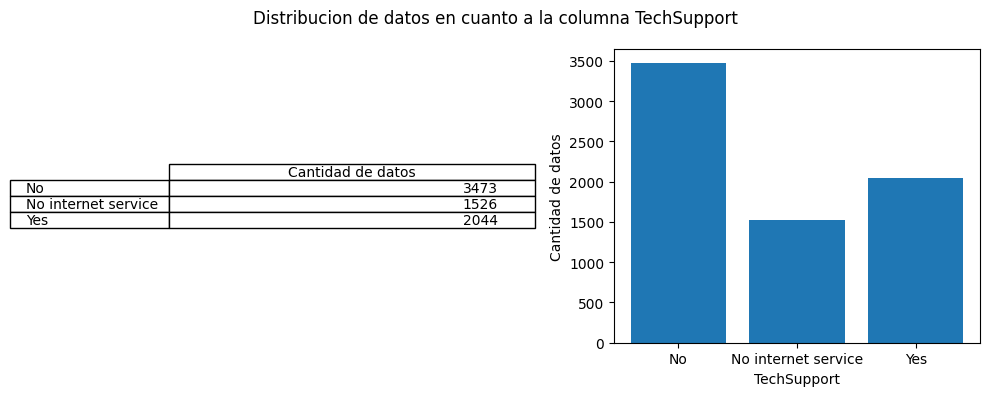

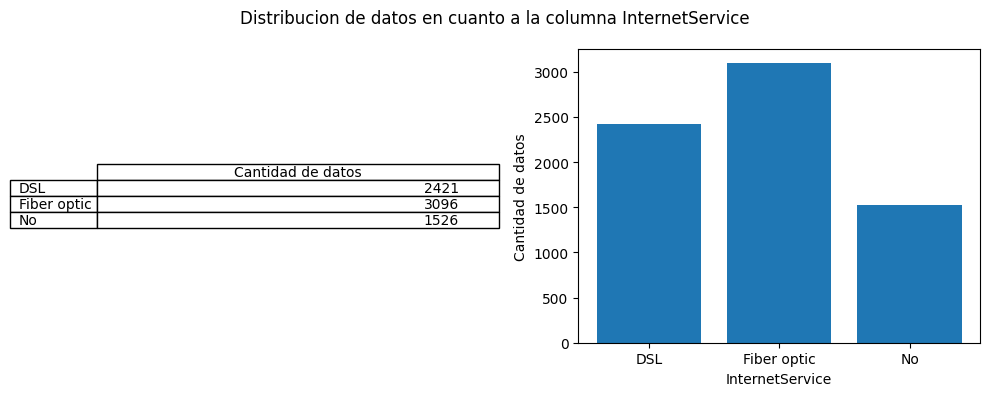

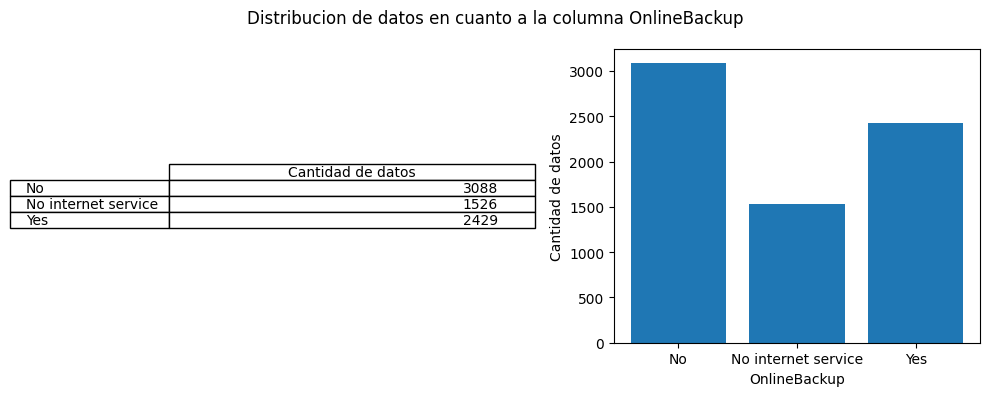

In [5]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_columns = list(set(cols) - set(num_cols) - set(['customerID']))
width = 0.35

for column in cat_columns:
    aux = df.groupby(column).count()
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    fig.suptitle(f'Distribucion de datos en cuanto a la columna {column}')
    fig.patch.set_visible(True)
    ax[0].axis('off')
    ax[0].axis('tight')
    ax[0].table(cellText=[[x] for x in aux.customerID], colLabels=['Cantidad de datos'], rowLabels=list(aux.index), loc='center')
    ax[1].bar(list(aux.index), aux.customerID)
    ax[1].set_ylabel('Cantidad de datos')
    ax[1].set_xlabel(column)
    fig.tight_layout()
    plt.show()

Se revisa la distribucion de las categorias de Churn para ver si se tiene un equilibrio al respecto.

Se tienen 1869 registros con Churn positivos y 5174 negativos, se trabajara con esta información completa

### Analisis de valores nulos

<Axes: >

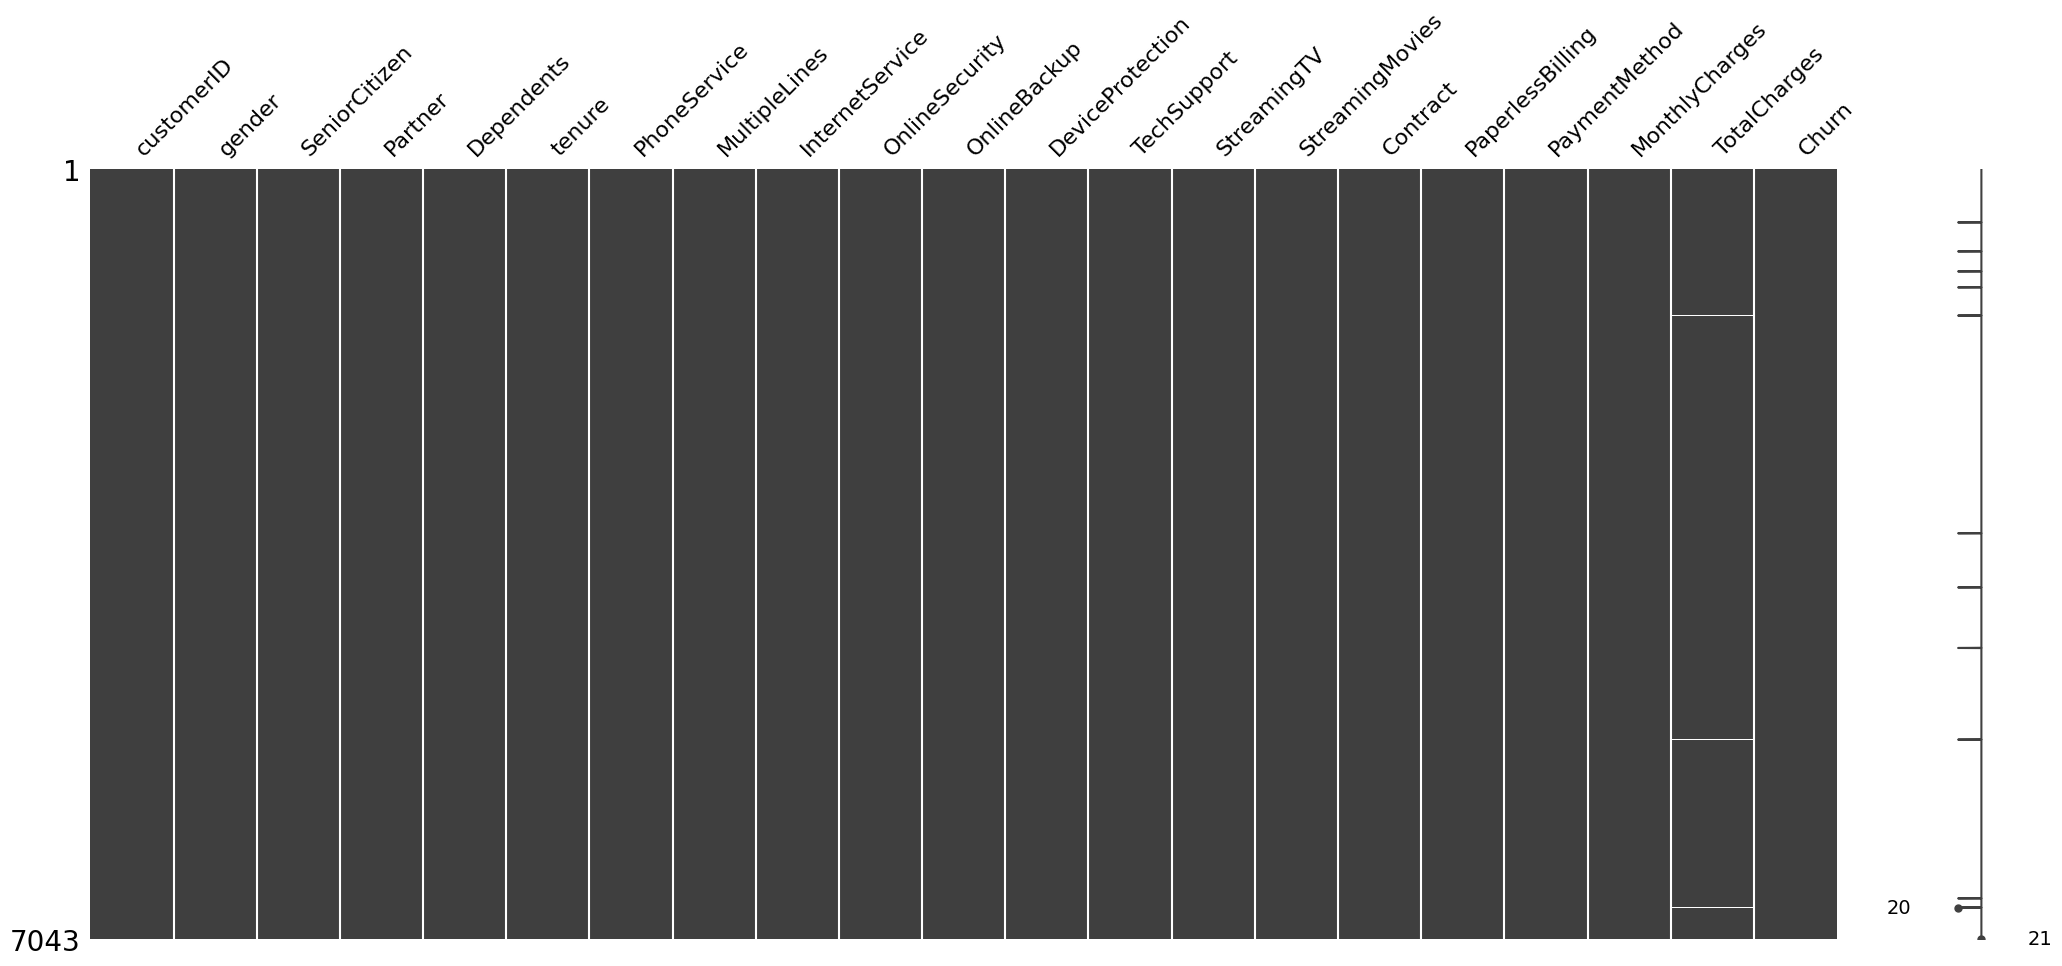

In [6]:
msngo.matrix(df)

Se observan registros con valores nulos en columna TotalCharges, se proceden a examinar

In [7]:
df[df.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Ya que son 11 registros negativos se dejaran fuera de la muestra dado que tenemos muchos mas negativos que positivos.

Adicional se hace drop de la columna customerID porque no tiene valor para el modelo.

In [8]:
df = df[df.TotalCharges.isna() == False].drop(columns=['customerID'])

## Preprocesar los datos, incluyendo la limpieza, la transformación y la normalización de las características según sea necesario.

Dado que en varias columnas hay valores si y no, tambien se encuentran valores como No Internet Service por ejemplo que es un No, estos se cambiaran por el valor no para dejarlo cerrado

In [9]:
df.TechSupport = df.TechSupport.apply(lambda x: 'Yes' if x == 'Yes' else 'No')
df.MultipleLines = df.MultipleLines.apply(lambda x: 'Yes' if x == 'Yes' else 'No')
df.DeviceProtection = df.DeviceProtection.apply(lambda x: 'Yes' if x == 'Yes' else 'No')
df.OnlineSecurity = df.OnlineSecurity.apply(lambda x: 'Yes' if x == 'Yes' else 'No')
df.StreamingMovies = df.StreamingMovies.apply(lambda x: 'Yes' if x == 'Yes' else 'No')
df.OnlineBackup = df.OnlineBackup.apply(lambda x: 'Yes' if x == 'Yes' else 'No')
df.StreamingTV = df.StreamingTV.apply(lambda x: 'Yes' if x == 'Yes' else 'No')

### Variables categoricas a one hot encoder

Pasamos todas las variables categoricas a one hot encoder para entregarle la informacion al modelo

In [10]:
cat_columns = set(cat_columns) - set(['Churn'])

df_one_hot = df.copy()

for col in cat_columns:
    one_hot = pd.get_dummies(df_one_hot[col], prefix=col)
    df_one_hot = df_one_hot.drop(columns=col)
    df_one_hot= df_one_hot.join(one_hot)

df_one_hot.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,StreamingMovies_No,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,MultipleLines_No,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_Yes,gender_Female,gender_Male,OnlineSecurity_No,OnlineSecurity_Yes,StreamingTV_No,StreamingTV_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Partner_No,Partner_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineBackup_No,OnlineBackup_Yes
0,0,1,29.85,29.85,No,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,False,False,True
1,0,34,56.95,1889.50,No,True,False,True,False,True,False,False,True,False,True,False,True,True,False,False,True,False,True,False,False,False,False,True,True,False,False,True,True,False,True,False,False,True,False
2,0,2,53.85,108.15,Yes,True,False,False,True,True,False,True,False,False,True,False,True,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,True,False,True,False,False,False,True
3,0,45,42.30,1840.75,No,True,False,True,False,True,False,False,True,False,True,False,True,True,False,False,True,False,True,False,True,False,False,False,True,False,True,False,False,True,True,False,False,True,False
4,0,2,70.70,151.65,Yes,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,True,False,True,False


## Dividir los datos en conjuntos de entrenamiento y prueba.

In [11]:
X = df_one_hot[list(set(df_one_hot.columns) - set(['Churn']))]
y = df_one_hot['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=40)

## Entrenar al menos 3 algoritmos y optimizar sus hiperparametros

Procedemos a entrenar los algoritmos de ML, en este caso se usara Random Forest, KNN y SVM.

Dado que el objetivo del modelo es detectar la mayor parte de los churns, se usara como metrica para decidir el mejor modelo el Recall del Yes, tratando de optimizar la cantidad de churns reconocidos del total de reconocidos

### Random Forest

In [12]:
resultados_rf = []
estimators = [10, 50, 100, 500, 1000]
max_depths = [10, 20, 30]

for combinacion in itertools.product(estimators, max_depths):
    estimator = combinacion[0]
    max_depth = combinacion[1]
    
    forest = RandomForestClassifier(n_estimators=estimator, n_jobs=10, max_depth=max_depth)
    history = forest.fit(X_train , y_train)
    predictions = forest.predict(X_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    resultados_rf.append([score, medidas])

for combinacion, resultado in zip(itertools.product(estimators, max_depths), resultados_rf):
    print("Estimadores: {e}, Profundidad Max: {pm}, Accuraccy: {a}, Precision: {p}, Recall: {r}, F-Score:{f}".format(
        e=combinacion[0],
        pm=combinacion[1],
        a=float("%.4f" % resultado[0]),
        p=float("%.4f" % resultado[1][0][0]),
        r=float("%.4f" % resultado[1][1][0]),
        f=float("%.4f" % resultado[1][2][0]) 
))

Estimadores: 10, Profundidad Max: 10, Accuraccy: 0.7932, Precision: 0.8466, Recall: 0.8829, F-Score:0.8643
Estimadores: 10, Profundidad Max: 20, Accuraccy: 0.7697, Precision: 0.823, Recall: 0.881, F-Score:0.851
Estimadores: 10, Profundidad Max: 30, Accuraccy: 0.7591, Precision: 0.8127, Recall: 0.88, F-Score:0.845
Estimadores: 50, Profundidad Max: 10, Accuraccy: 0.7939, Precision: 0.8448, Recall: 0.8867, F-Score:0.8652
Estimadores: 50, Profundidad Max: 20, Accuraccy: 0.7697, Precision: 0.827, Recall: 0.8743, F-Score:0.85
Estimadores: 50, Profundidad Max: 30, Accuraccy: 0.7733, Precision: 0.8272, Recall: 0.88, F-Score:0.8528
Estimadores: 100, Profundidad Max: 10, Accuraccy: 0.7918, Precision: 0.8432, Recall: 0.8857, F-Score:0.8639
Estimadores: 100, Profundidad Max: 20, Accuraccy: 0.7704, Precision: 0.8332, Recall: 0.8657, F-Score:0.8491
Estimadores: 100, Profundidad Max: 30, Accuraccy: 0.7683, Precision: 0.8273, Recall: 0.8714, F-Score:0.8488
Estimadores: 500, Profundidad Max: 10, Accura

Se procede a elegir los parametros del modelo con mejor recall y precision: 
- Estimadores: 50, Profundidad Max: 20

### KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

resultados_knn = []
n_neighbors = [2, 4, 8, 10, 20]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
for combination in itertools.product(n_neighbors, weights, algorithm):
    
    knn_model = KNeighborsClassifier(
        n_neighbors=combination[0],
        weights=combination[1],
        algorithm=combination[2],
        n_jobs=10
    )
    history = knn_model.fit(X_train , y_train)
    predictions = knn_model.predict(X_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    resultados_knn.append([score, medidas])

for combination, resultado in zip(itertools.product(n_neighbors, weights, algorithm), resultados_knn):
    print("N N: {n}, Weight: {w}, Algorithm: {al}, Accuraccy: {a}, Precision: {p}, Recall: {r}, F-Score:{f}".format(
        n=combination[0],
        w=combination[1],
        al=combination[2],
        a=float("%.4f" % resultado[0]),
        p=float("%.4f" % resultado[1][0][0]),
        r=float("%.4f" % resultado[1][1][0]),
        f=float("%.4f" % resultado[1][2][0]) 
))

N N: 2, Weight: uniform, Algorithm: auto, Accuraccy: 0.7669, Precision: 0.7969, Recall: 0.9229, F-Score:0.8553
N N: 2, Weight: uniform, Algorithm: ball_tree, Accuraccy: 0.7647, Precision: 0.7949, Recall: 0.9229, F-Score:0.8541
N N: 2, Weight: uniform, Algorithm: kd_tree, Accuraccy: 0.7647, Precision: 0.7949, Recall: 0.9229, F-Score:0.8541
N N: 2, Weight: uniform, Algorithm: brute, Accuraccy: 0.7669, Precision: 0.7969, Recall: 0.9229, F-Score:0.8553
N N: 2, Weight: distance, Algorithm: auto, Accuraccy: 0.7114, Precision: 0.8188, Recall: 0.7876, F-Score:0.8029
N N: 2, Weight: distance, Algorithm: ball_tree, Accuraccy: 0.7107, Precision: 0.8174, Recall: 0.7886, F-Score:0.8027
N N: 2, Weight: distance, Algorithm: kd_tree, Accuraccy: 0.7107, Precision: 0.8174, Recall: 0.7886, F-Score:0.8027
N N: 2, Weight: distance, Algorithm: brute, Accuraccy: 0.7114, Precision: 0.8188, Recall: 0.7876, F-Score:0.8029
N N: 4, Weight: uniform, Algorithm: auto, Accuraccy: 0.7669, Precision: 0.8039, Recall: 0.

En este caso nos quedaremos con los parametros
- N N: 20, Weight: uniform, Algorithm: auto -> Accuraccy: 0.7797, Precision: 0.8146, Recall: 0.9124, F-Score:0.8607

Ya que en general tienen los mejores resultados, aunque hay otro modelo con resultados similares
- N N: 2, Weight: uniform, Algorithm: auto, Accuraccy: 0.7669, Precision: 0.7969, Recall: 0.9229, F-Score:0.8553

Pero sacrificaremos un poco el recall para tener mejores metricas en general


### SVM - SVC

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



resultados_svm = []
kernel = ['rbf']
c = [1, 10, 100]
gamma = [0.01, 0.1]


for combination in itertools.product(kernel, c, gamma):
    
    svm_model = SVC(
        kernel = combination[0],
        C = combination[1],
        gamma = combination[2]
    )
    history = svm_model.fit(X_train , y_train)
    predictions = svm_model.predict(X_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    resultados_svm.append([score, medidas])

for combination, resultado in zip(itertools.product(kernel, c, gamma), resultados_svm):
    print("Kernel: {k}, C: {c}, Gamma: {g}, Accuraccy: {a}, Precision: {p}, Recall: {r}, F-Score:{f}".format(
        k=combination[0],
        c=combination[1],
        g=combination[2],
        a=float("%.4f" % resultado[0]),
        p=float("%.4f" % resultado[1][0][0]),
        r=float("%.4f" % resultado[1][1][0]),
        f=float("%.4f" % resultado[1][2][0])
))

Kernel: rbf, C: 1, Gamma: 0.01, Accuraccy: 0.7719, Precision: 0.8217, Recall: 0.8867, F-Score:0.853
Kernel: rbf, C: 1, Gamma: 0.1, Accuraccy: 0.774, Precision: 0.7773, Recall: 0.9771, F-Score:0.8658
Kernel: rbf, C: 10, Gamma: 0.01, Accuraccy: 0.7385, Precision: 0.8193, Recall: 0.8333, F-Score:0.8263
Kernel: rbf, C: 10, Gamma: 0.1, Accuraccy: 0.7683, Precision: 0.7811, Recall: 0.9581, F-Score:0.8606
Kernel: rbf, C: 100, Gamma: 0.01, Accuraccy: 0.7299, Precision: 0.8154, Recall: 0.8248, F-Score:0.8201
Kernel: rbf, C: 100, Gamma: 0.1, Accuraccy: 0.7655, Precision: 0.7786, Recall: 0.9581, F-Score:0.8591


Se selecciona la configuracion
- Kernel: rbf, C: 1, Gamma: 0.1, Accuraccy: 0.774, Precision: 0.7773, Recall: 0.9771, F-Score:0.8658

## Evaluar el rendimiento de los modelos utilizando métricas de evaluación pertinentes, como precisión, sensibilidad, valor F1, entre otras.

In [15]:
def print_roc_curve(list_test, predictions):
    fpr, tpr, _ = roc_curve(
        [1 if val == 'Yes' else 0 for val in list_test], 
        [1 if val == 'Yes' else 0 for val in predictions]
    )
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=1.5, label=f'Curva ROC (AUC = {roc_auc})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label=f'Chance Label (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Cross validation

In [16]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
num_classes = 2

acurracy mean 0.7845564463985516
media precision 0.7242811602577829
media recall 0.6882888687349101
media fscore 0.7008809019761335
media support 351.59999999999997


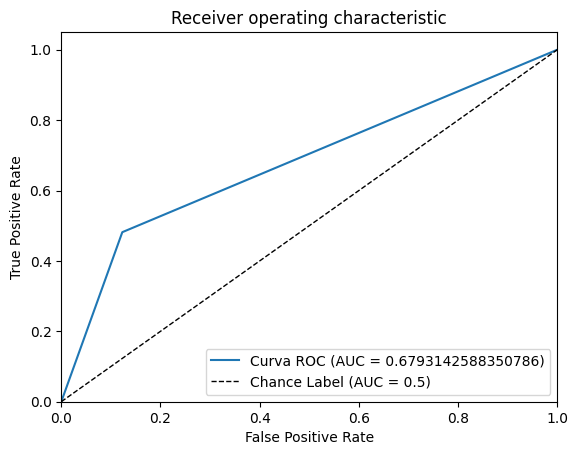

In [17]:

resultados_rf = []
num_classes = 2
for valores_entrenamiento, valores_testeo in kf.split(X):
    x_train = X.iloc[valores_entrenamiento]
    x_test = X.iloc[valores_testeo]
    y_train = y.iloc[valores_entrenamiento]
    y_test = y.iloc[valores_testeo]
    
    rf = RandomForestClassifier(n_estimators=50, n_jobs=10, max_depth=20)
    history = rf.fit(x_train , y_train)
    predictions = rf.predict(x_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    resultados_rf.append([score, medidas])

print("acurracy mean",np.array([res[0] for res in resultados_rf]).mean())
print("media precision",np.array([np.array([res[1][0][i] for res in resultados_rf]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[1][1][i] for res in resultados_rf]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[1][2][i] for res in resultados_rf]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[1][3][i] for res in resultados_rf]).mean() for i in range(num_classes)]).mean())

print_roc_curve(list(y_test), predictions)

acurracy mean 0.7837031633906635
media precision 0.7362373891559116
media recall 0.6510119200683997
media fscore 0.6687839311616266
media support 351.59999999999997


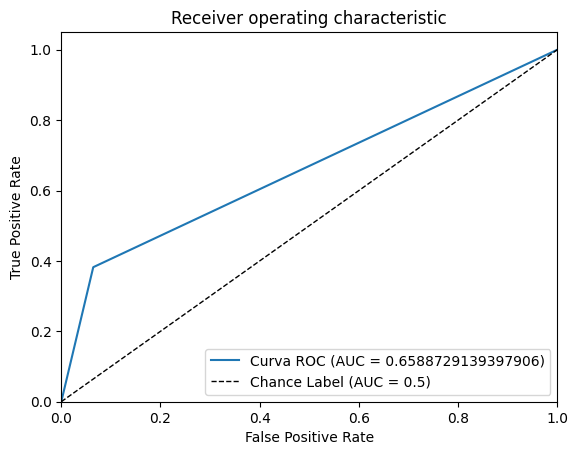

In [18]:
knn_resultados = []
for valores_entrenamiento, valores_testeo in kf.split(X):
    x_train = X.iloc[valores_entrenamiento]
    x_test = X.iloc[valores_testeo]
    y_train = y.iloc[valores_entrenamiento]
    y_test = y.iloc[valores_testeo]
    
    knn = KNeighborsClassifier(
        n_neighbors=20,
        weights='uniform',
        algorithm='auto',
        n_jobs=10
    )
    history = knn.fit(x_train , y_train)
    predictions = knn.predict(x_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    knn_resultados.append([score, medidas])

print("acurracy mean",np.array([res[0] for res in knn_resultados]).mean())
print("media precision",np.array([np.array([res[1][0][i] for res in knn_resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[1][1][i] for res in knn_resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[1][2][i] for res in knn_resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[1][3][i] for res in knn_resultados]).mean() for i in range(num_classes)]).mean())

print_roc_curve(list(y_test), predictions)

acurracy mean 0.7642221243372559
media precision 0.7574034287832421
media recall 0.5748077127456582
media fscore 0.5675333408657293
media support 351.59999999999997


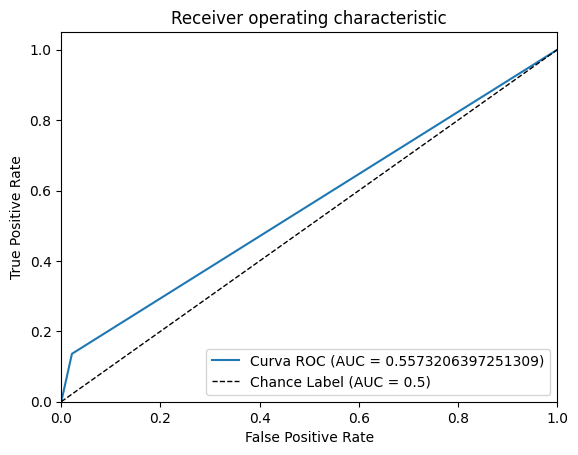

In [19]:
svm_resultados = []
for valores_entrenamiento, valores_testeo in kf.split(X):
    x_train = X.iloc[valores_entrenamiento]
    x_test = X.iloc[valores_testeo]
    y_train = y.iloc[valores_entrenamiento]
    y_test = y.iloc[valores_testeo]

    svm = SVC(
        kernel = 'rbf',
        C = 1,
        gamma = 0.1
    )
    history = svm.fit(x_train , y_train)
    predictions = svm.predict(x_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    svm_resultados.append([score, medidas])

print("acurracy mean",np.array([res[0] for res in svm_resultados]).mean())
print("media precision",np.array([np.array([res[1][0][i] for res in svm_resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[1][1][i] for res in svm_resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[1][2][i] for res in svm_resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[1][3][i] for res in svm_resultados]).mean() for i in range(num_classes)]).mean())

print_roc_curve(list(y_test), predictions)

In [20]:
df_stats = pd.DataFrame({
   'Model': ['Random Forest', 'KNN', 'SVM'],
   'Acurracy': ['0.7824221275701538', '0.7837031633906635', '0.7642221243372559'],
   'Precision': ['0.7211793611791816', '0.7362373891559116', '0.7574034287832421'],
   'Recall': ['0.6875149787342911', '0.6510119200683997', '0.5748077127456582'],
   'Fscore': ['0.6994020961642438', '0.6687839311616266', '0.5675333408657293']
})
df_stats.set_index('Model', inplace=True)
df_stats

,Acurracy,Precision,Recall,Fscore
Model,,,,
Random Forest,0.7824221275701538,0.7211793611791816,0.6875149787342911,0.6994020961642438
KNN,0.7837031633906635,0.7362373891559116,0.6510119200683997,0.6687839311616266
SVM,0.7642221243372559,0.7574034287832421,0.5748077127456582,0.5675333408657293


Como es posible observar en los resultados se tiene que el mejor modelo es el Random Forest seguido por el KNN y por ultimo el SVM, esto tambien se ve en el AUC de la curva roc de Random Forest con 0.67, pequeña diferencia con el de KNN de 0.65 y gran diferencia con SVM de 0.55